# Lab 8 - Text Mining
---
**Summer 2025 - Intructor: Joyce Yang**

**Adapted from teaching materials by Prof. Chris Volinksy Fall 2024**

In this notebook we will be using features extracted from text as input into supervised (predictive) models.

This notebook contains optional task. If you have time, have fun working on optional task. You won't be penalize if you didn't finish optional task.

**Before we begin, remember to save this notebook IN YOUR OWN GOOGLE DRIVE**.  That way you have your own copy to work on, edit and share.

In [24]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pylab as plt
%matplotlib inline

## Application: Analyzing Customer Tweets for an Airline Company

Our problem setting: You've been hired by Trans American Airlines (TAA) as a business analytics professional. One of the top priorities of TAA is  customer service. For TAA, it is of utmost importance to identify whenever customers are unhappy with the way employees have treated them. You've been hired to analyze twitter data in order to detect whenever a customer has complaints about flight attendants. Tweets suspected to be related to flight attendant complaints should be forwarded directly to the customer service department in order to track the issue and take corrective actions.  

Let's start by loading the training data, which has been hand labelled with the subject of the tweet and the text of the tweet itself.

[Click here](https://drive.google.com/uc?download&id=1zgbAtmg3Pm2Wg7vMWujsbT2sUBe__Qy7) to download the file "TAA_tweets.csv"

### Data Loading and Preprocess

In [1]:
#select file from computer

from google.colab import files
uploaded = files.upload()

Saving TAA_tweets.csv to TAA_tweets.csv


This dataset contains multiple interesting columns. In this lab, we only are about the feature `text` (tweet content) and `negativereason` (label, whether people complain about the airlines.)

In [5]:
tweets = pd.read_csv("TAA_tweets.csv")

pd.set_option("display.max_colwidth", 1000) # To display up to 1000 characters
tweets[['negativereason','text']].head()

,negativereason,text
0,NaN,@TAA What @dhepburn said.
1,NaN,@TAA plus you've added commercials to the experience... tacky.
2,NaN,@TAA I didn't today... Must mean I need to take another trip!
3,Bad Flight,"@TAA it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,Can't Tell,@TAA and it's a really big bad thing about it


Let's take a look at what do people complain about in Twitter

In [6]:
tweets.negativereason.value_counts()

,count
negativereason,
Customer Service Issue,2910
Late Flight,1665
Can't Tell,1190
Cancelled Flight,847
Lost Luggage,724
Bad Flight,580
Flight Booking Problems,529
Flight Attendant Complaints,481
longlines,178


#### Task 1 Process Data

Basically, we can see 10 types of negativereasons. To make this lab easy (binary classification), let's focus on `Flight Attendant Complaints`.

1. Create an additional feature named `is_complaint`, which should be a binary variable, if `negativereason` is `Flight Attendant Complaints`, then `is_complaint` is 1. (this would be our target.)
2. Is this data balanced? If not, how skew it is?
3. Create X and Y, where we only keep `text` as a "feature" and Y is `is_complaint`.
4. Train Test Split into 80/20.


In [25]:
#'is_complaint' binary target feature
tweets['is_complaint'] = (tweets['negativereason'] ==
'Flight Attendant Complaints').astype(int)
#balance data
counts = tweets['is_complaint'].value_counts()
print("Counts of each class:")
print(counts)
total = counts.sum()
skew_ratio = counts.max() / counts.min() if counts.min() > 0 else None
print(f"Skew ratio (majority/minority): {skew_ratio:.2f}" if skew_ratio else "Cannot calculate skew ratio due to zero count")

#Prepare X and Y
X = tweets['text']
Y = tweets['is_complaint']

# Train-Test Split 80/20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Counts of each class:
is_complaint
0    14159
1      481
Name: count, dtype: int64
Skew ratio (majority/minority): 29.44
Training set size: 11712
Test set size: 2928


### Feature Engineering & Evaluation

We will learn what we can do about text. Bascially, we will try to extract features from text.

#### Term Frequency Matrix using Binary CountVectorizer

##### Task 2 Distinct Word Counts

How can we turn the large amount of text for each record into useful features?

We want to create a Term Frequency (TF) matrix, which keeps track of whether or not a word appears in a document/record. The easiest TF matrix is binary - it simply has zeros and ones for which words appear in the document.

You can do this in sklearn with a `CountVectorizer()` and setting `binary` to true. The process is very similar to how you `fit` a model: you will fit a CounterVectorizer(). This will figure out what words exist in your data.

Help yourself to see the outcome of binary_vectorizer content with `binary_vectorizer.vocabulary_`. How big is the vocabulary in tweets?

In [26]:
# Create the binary vectorizer
binary_vectorizer = CountVectorizer(binary=True)
# Fit the vectorizer to the text data
X_binary = binary_vectorizer.fit_transform(tweets['text'])

# View the vocabulary dictionary
vocab = binary_vectorizer.vocabulary_

# Check the size of the vocabulary
print("Vocabulary size:", len(vocab))

Vocabulary size: 15055


##### Task 3 Create the TF Matrix

Now that we have a list of the words are in the data, we can transform our text into a clean matrix.
1. Use `.transform()` on the raw data using our fitted CountVectorizer(). You will do this for the training and test data. Name the outcome `X_train_binary` and `X_test_binary`
2. What happened to our training and testing data?


In [27]:
X_train_binary = binary_vectorizer.transform(X_train)
X_test_binary = binary_vectorizer.transform(X_test)

# Let's check the shapes of the transformed data
print(f"X_train_binary shape: {X_train_binary.shape}")
print(f"X_test_binary shape: {X_test_binary.shape}")

X_train_binary shape: (11712, 15055)
X_test_binary shape: (2928, 15055)


##### Task 4 Visualize TF Matrix

If you look at the `X_test_binary` output above, you will see that it is being stored in a *sparse* matrix (as opposed to the typical dense matrix, *sparse* refers to matrix that contains many zeros) that is 3k rows long and 13k columns. The rows here are **number of records** in the original data and the columns are number of **distinct words**. Given the shape, this means there are 39m cells that should have values. However, with the following code we can see that only 46k cells (~0.12%) of the cells have values!

Why is this?

**[Without an attempt of answering why will be considered as incomplete lab]**

In [28]:
# Recall that 13183 is the index for "you"
X_test_binary[0:20, 13180:13200].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

answer: 39,000,000 elements, but some words in vocabulary won't even appear once

To save the memory space, sklearn uses a optimized storage method to store sparse matrix in memory. *These optimized storing methods will fall into applied math and computer science optimization research*. Only values that are not zero are stored. This saves a ton of space! However, this also complex the way to visualize the matrix as shown in the above code.

##### Task 5 Model Building with Extracted Features

Now that we have a ton of features (one for every word!) let's try using a logistic regression model to predict which tweets are about flight attendant complaints.  

1. Instanize a Logistic Regression model with `liblinear` solver and `C=1`.
2. Fit with the training dataset (Your extracted features from original text, the matrix)
3. Predict on testing dataset
4. Evaluate with AUC
5. Plot the ROC AUC curve

AUC Score: 0.8523


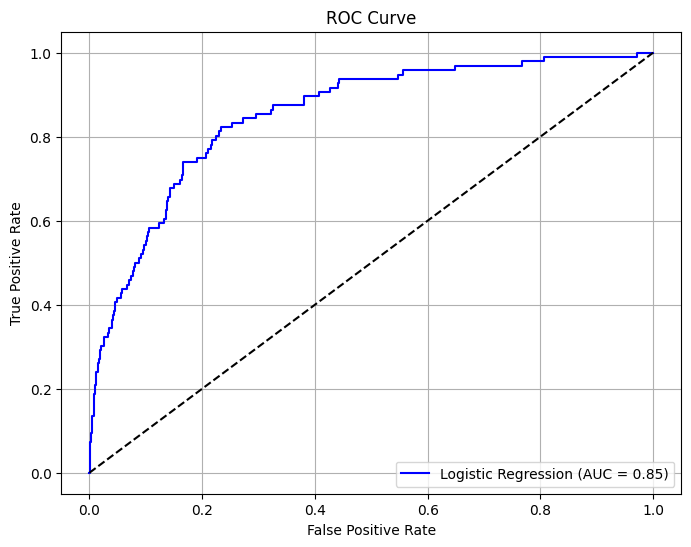

In [29]:
model = LogisticRegression(solver='liblinear', C=1, random_state=42)
model.fit(X_train_binary, Y_train)
Y_probs = model.predict_proba(X_test_binary)[:, 1]
auc_score = roc_auc_score(Y_test, Y_probs)
print(f"AUC Score: {auc_score:.4f}")
fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Term Frequency Matrix using Counts


##### Task 6

Instead of using a 0 or 1 to represent the occurence of a word, we can use the actual counts. We do this the same way as before, but now we leave `binary` set to `false` (the default value).

Do everything above again with the new setting.
1. Create the TF matrix that are not binary, instead with actual counts
2. Train a Logistic Regression Model with new features
3. Evaluate on testing dataset via AUC
4. Plot the ROC AUC Curve.

AUC Score (Count Features): 0.8524


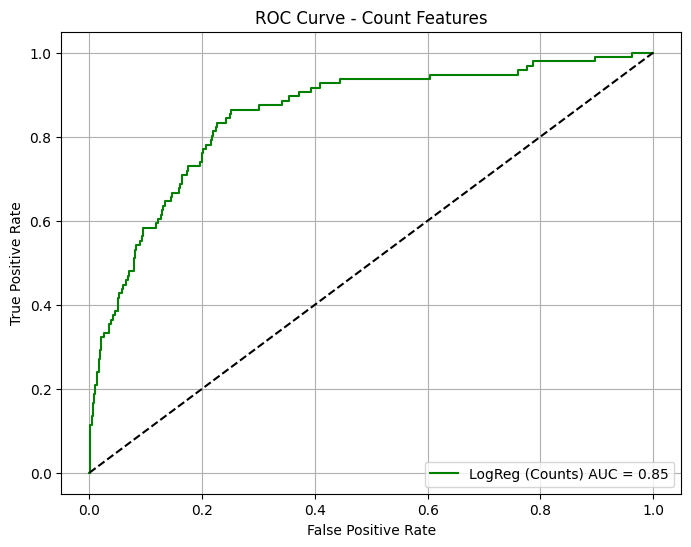

In [32]:
# Create and fit a new vectorizer
count_vectorizer = CountVectorizer()  # binary=False is default
count_vectorizer.fit(X_train)

# Transform the data
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)
model_counts = LogisticRegression(solver='liblinear', C=1, random_state=42)
model_counts.fit(X_train_counts, Y_train)

Y_probs_counts = model_counts.predict_proba(X_test_counts)[:, 1]

auc_score_counts = roc_auc_score(Y_test, Y_probs_counts)
print(f"AUC Score (Count Features): {auc_score_counts:.4f}")

fpr_counts, tpr_counts, _ = roc_curve(Y_test, Y_probs_counts)

#plot figyre
plt.figure(figsize=(8, 6))
plt.plot(fpr_counts, tpr_counts, label=f'LogReg (Counts) AUC = {auc_score_counts:.2f}', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Count Features')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### TF-IDF Vectorizer

##### Task 7

Often we can improve performance by combining the term frequency in a docuemnt with the term frequency across documents (inverse document frequency - IDF). This way more important (rare) words get more weight. This is called a TF-IDF matrix.  

Python does this via `TfidfVectorizer()`

Again, do everything like above.
1. Create TFIDF matrix with `TfidfVectorizer()`
2. Train a Logistic Regression Model with new features
3. Evaluate on testing dataset via AUC
4. Plot the ROC AUC Curve.

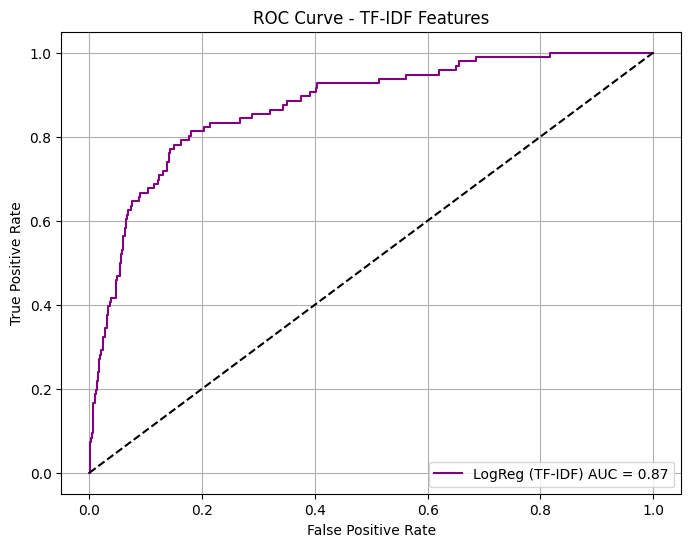

AUC Score (Count Features): 0.8524


In [43]:
# Create and fit the vectorizer on training data
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

# Transform training and test data
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model_tfidf = LogisticRegression(solver='liblinear', C=1, random_state=42)
model_tfidf.fit(X_train_tfidf, Y_train)

Y_probs_tfidf = model_tfidf.predict_proba(X_test_tfidf)[:, 1]

fpr_tfidf, tpr_tfidf, _ = roc_curve(Y_test, Y_probs_tfidf)
auc_score_tfidf = roc_auc_score(Y_test, Y_probs_tfidf)
plt.figure(figsize=(8, 6))

plt.plot(fpr_tfidf, tpr_tfidf, label=f'LogReg (TF-IDF) AUC = {auc_score_tfidf:.2f}', color='purple')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TF-IDF Features')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC Score (Count Features): {auc_score_counts:.4f}")

#### More Arguments on Functions

The `CountVectorizer()` and `TfidfVectorizer()` functions have many options.

We discussed in class the importance of pre-processing, and some of that can be done within the Vectorizer functions.  For instance, you can remove **stopwords** which are unimportant English words.  

You can also include. **n-grams** which are combinations of words which appear often.  **Bigrams** (n-grams with n=2) can find two word phrases that are often used and include them in the TF/IDF matrices.  Be careful, increasing n will increase the complexity of your model.

##### [Optional] Task

Let's focus on `TfidfVectorizer()`. You can remove the stop words by setting `stop_words='english'` and change the n-grams by setting `ngram_range`.

Now estimate the performance, basically, auc and auc-roc curve with `TfidfVectorizer()` that removes the stop words, and ngram_range is unigram or bigrams, `ngram_range=(1,2)`

AUC Score (TF-IDF with removals):0.8933


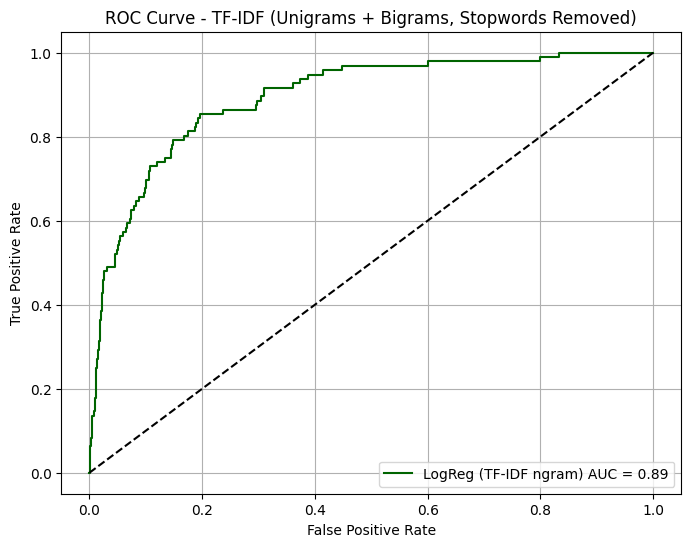

In [41]:
# Create and fit the vectorizer
tfidf_vectorizer_ngram = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_vectorizer_ngram.fit(X_train)

# Transform the training and test sets
X_train_tfidf_ngram = tfidf_vectorizer_ngram.transform(X_train)
X_test_tfidf_ngram = tfidf_vectorizer_ngram.transform(X_test)

model_tfidf_ngram = LogisticRegression(solver='liblinear', C=1, random_state=42)
model_tfidf_ngram.fit(X_train_tfidf_ngram, Y_train)

Y_probs_tfidf_ngram = model_tfidf_ngram.predict_proba(X_test_tfidf_ngram)[:, 1]


auc_score_tfidf_ngram = roc_auc_score(Y_test, Y_probs_tfidf_ngram)
print(f"AUC Score (TF-IDF with removals):{auc_score_tfidf_ngram:.4f}")


fpr_tfidf_ngram, tpr_tfidf_ngram, _ = roc_curve(Y_test, Y_probs_tfidf_ngram)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tfidf_ngram, tpr_tfidf_ngram, label=f'LogReg (TF-IDF ngram) AUC = {auc_score_tfidf_ngram:.2f}', color='darkgreen')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TF-IDF (Unigrams + Bigrams, Stopwords Removed)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Naive and Multinomial Naive Bayes Models

Naive Bayes is a class of classification models built off of the idea that all words can be modelled independent of one another.  However, it only works for binary term frequency matrices.

Multinomial Naive Bayes (`MultinomialNB`) is an extension of Naive Bayes which works off of a CountVectorized matrix.

Using this model in sklearn works just the same as the other classification models we've seen ([More details here..](http://scikit-learn.org/stable/modules/naive_bayes.html))

Lets fit both of these and see which one performs better.

#### Task 8 Fit with Naive Bayes.

Note that Naive Bayes works only on Binary Matrix. Use `BernoulliNB` with `alpha=1` for Laplace option. Then evaluate the performance of BernouliNB on testing data.

In [37]:
from sklearn.naive_bayes import BernoulliNB

AUC Score (BernoulliNB): 0.7881


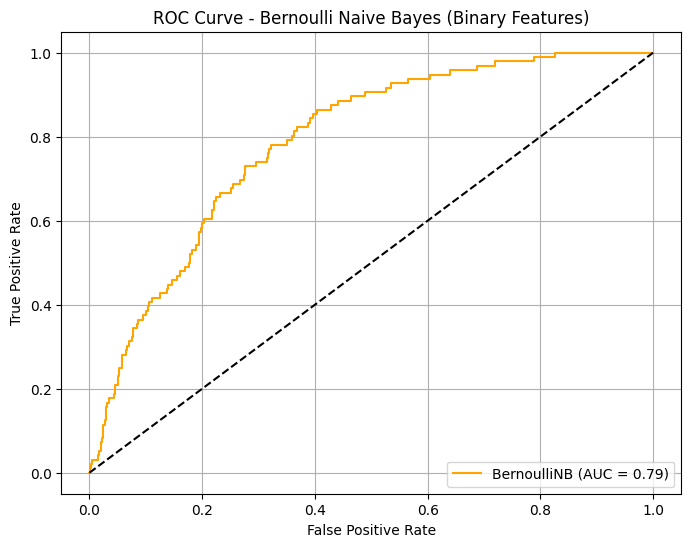

In [38]:
nb_model = BernoulliNB(alpha=1)
nb_model.fit(X_train_binary, Y_train)
Y_probs_nb = nb_model.predict_proba(X_test_binary)[:, 1]

auc_score_nb = roc_auc_score(Y_test, Y_probs_nb)
print(f"AUC Score (BernoulliNB): {auc_score_nb:.4f}")


fpr_nb, tpr_nb, _ = roc_curve(Y_test, Y_probs_nb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f'BernoulliNB (AUC = {auc_score_nb:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bernoulli Naive Bayes (Binary Features)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Task 9 Fit with MultinominalNB

MultinomialNB works perfectly for Count Matrix. Use `MultinomialNB()` with `alpha=1` for Laplace option. Then evaluate the performance of MultinomialNBNB on testing data.

In [39]:
from sklearn.naive_bayes import MultinomialNB

AUC Score (MultinomialNB): 0.6269


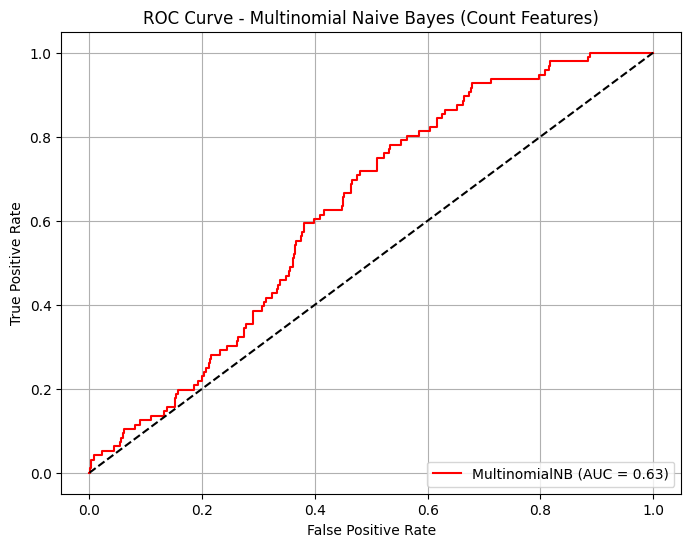

In [40]:
mnb_model = MultinomialNB(alpha=1)
mnb_model.fit(X_train_counts, Y_train)
Y_probs_mnb = mnb_model.predict_proba(X_test_counts)[:, 1]  # probability of class 1
auc_score_mnb = roc_auc_score(Y_test, Y_probs_mnb)
print(f"AUC Score (MultinomialNB): {auc_score_mnb:.4f}")

fpr_mnb, tpr_mnb, _ = roc_curve(Y_test, Y_probs_mnb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mnb, tpr_mnb, label=f'MultinomialNB (AUC = {auc_score_mnb:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multinomial Naive Bayes (Count Features)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Naive Bayes has a complexity hyperparameter that is typically tuned - the smoothing value **`alpha`**.  You can try to see whether tuning `alpha` helps improve on the results above. (Try values of `alpha < 1` - the default)


Also, there are other versions of naive Bayes, for instance  **Gaussian Naive Bayes (GNB):** can be used when we have other numeric features that we can use in the predictive model (like, say, the age of the tweeter).  Sometimes GNB and Bernoulli NB are combined when one has features of mixed types.  